<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры, не менее 0.59. Затем проверим *F1*-меру на тестовой выборке.

Измерим *AUC-ROC* и сравним её значение с *F1*-мерой.

## Подготовка данных

Подключаем необходимые библиотки:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample, shuffle
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

In [2]:
RANDOM_STATE = 0

Откроем файл с данными и рассмотрим содержимое

In [3]:
df = pd.read_csv('churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В признаке `Tensure` довольно много пропусков

Количество дубликотов в датафрейме:

In [5]:
df.duplicated().sum()

0

Изучим как распределены числовые признаки.

In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


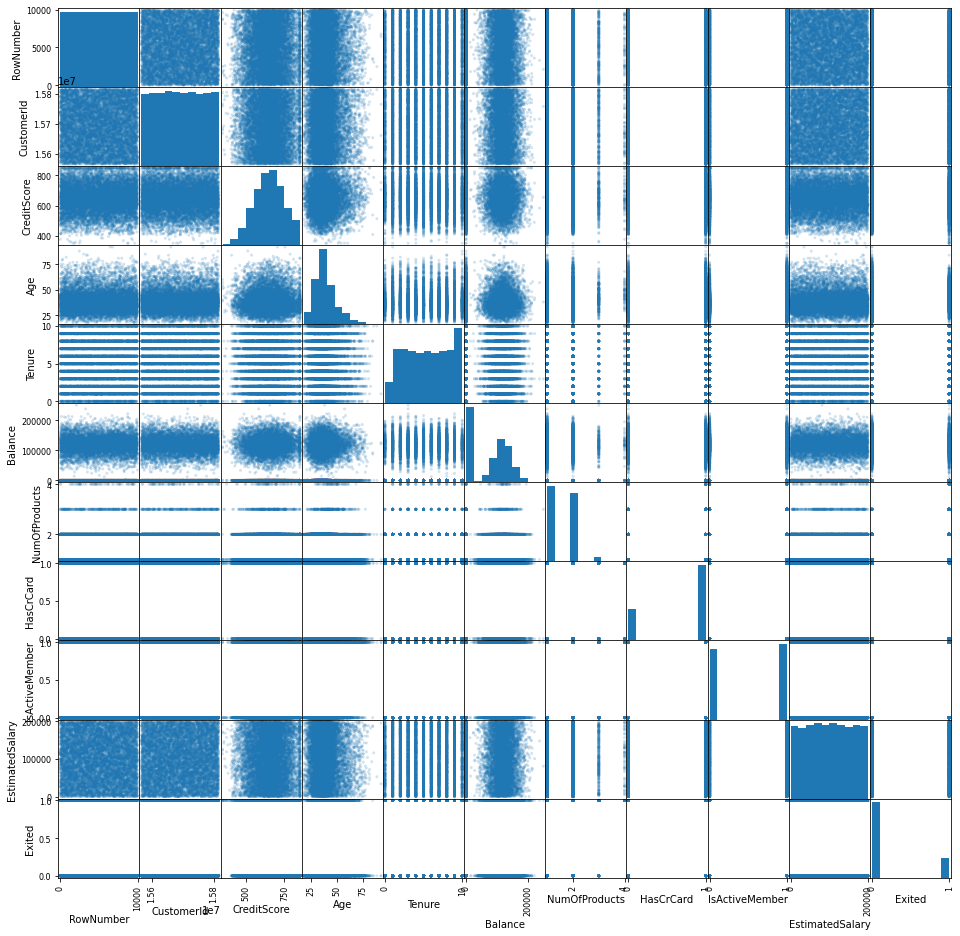

In [7]:
_ = pd.plotting.scatter_matrix(df, figsize=(16, 16), alpha=0.2)

Какой-то серьёзной корреляции между признаками на которых будем обучать модель не вижу.

Выбросов нет

Есть дисбаланс классов в нескольких признаках, в частности в целевом

Посмотрим какие значения есть в не числовых признаках

In [8]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [9]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

**Признаки**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

Уберем признаки, которые не несут особого смысла:

In [10]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

Я не знаю как повлияет на результат заполнение пропусков тем или иным способом. И это процентов десять данных. Возможно этот признак вовсе не влияет на целевой - тогда можно просто удалить столбец. Если это сделать сейчас, то мы так никогда и не узнаем ответ. Поэтому строки с пропусками запишем в отдельный датафрейм и удалим из основного набора данных.

In [11]:
df_dropped = df.loc[df.Tenure.isna()]
df_dropped.shape

(909, 11)

In [12]:
df.dropna(axis='index', how='any', inplace=True)
df.shape

(9091, 11)

**Вывод**

У нас хороший датасет. Нет ни выбросов, нет множества пропущеных или невалидных данных.

Сильной корреляции помежду признаками не видно, есть дисбаланс классов.

Примерно 9% данных в колонке `Tenure` пустые. Объекты с этими пропусками записаны в отдельный датафрейм, а из основного выброшены. Возможно мы можем безболезненно избавиться от этого признака и вернуть строки в обучающую выборку.

`RowNumber`, `CustomerId`, `Surname` выброшены т.к. не несут для нас смысла.

## Исследование задачи

В принципе, на матрице рассеяния видно как распределены числовые значения, но здесь мы акцекнтируем внимание на дисбалансе классов. Баланс классов номинальных переменных покажем спомощью пайчартов:

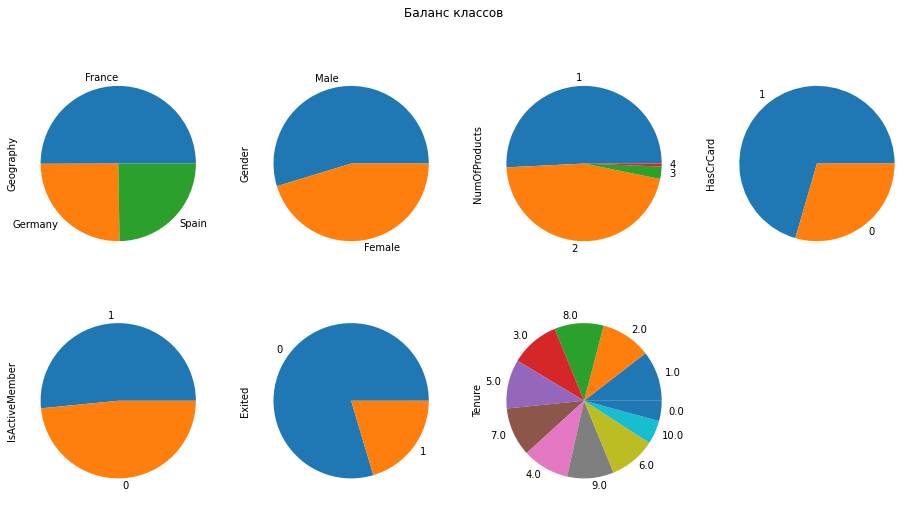

In [13]:
columns = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Tenure']

plt.figure(figsize=(16, 8)).suptitle('Баланс классов')

for index in range(len(columns)):
    plt.subplot(2, 4, index+1)
    df[columns[index]].value_counts().plot(kind='pie')

Заглянем также в отброшенную часть датасета. Пропорции дисбаланса повторяют основной массив данных. Значит удаление этих строк не повлияло на баланс классов.

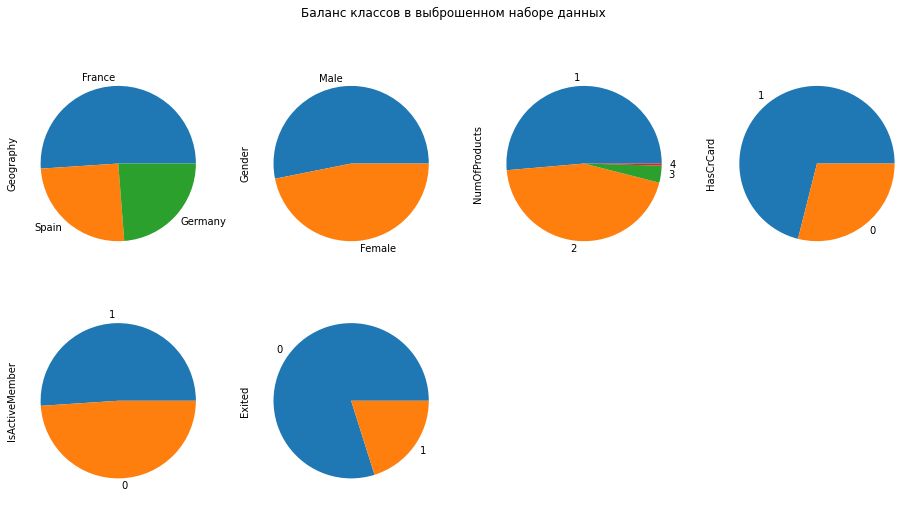

In [14]:
columns = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

plt.figure(figsize=(16, 8)).suptitle('Баланс классов в выброшенном наборе данных')

for index in range(len(columns)):
    plt.subplot(2, 4, index+1)
    df_dropped[columns[index]].value_counts().plot(kind='pie')

Чтобы оценить как распределяются количественные значения воспользуемся гистограммой.

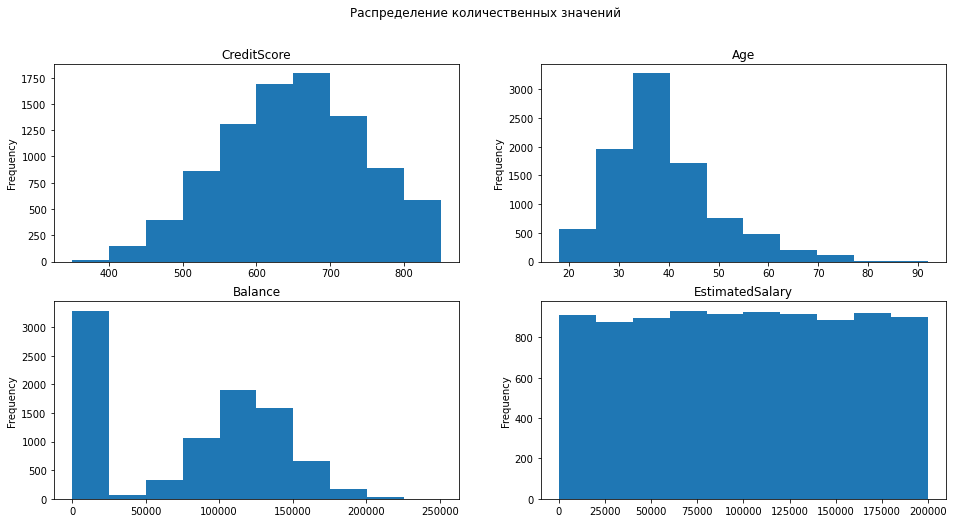

In [15]:
columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

plt.figure(figsize=(16, 8)).suptitle('Распределение количественных значений')

for index in range(len(columns)):
    plt.subplot(2, 2, index+1)
    plt.title(columns[index])
    df[columns[index]].plot(kind='hist')

У нас в наборе данных есть пара признаков, выраженных в текстовом формате (страна проживания и пол). Для перекодирования в числовой формат воспользуемся OHE.

In [16]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

Выделим целевой признак и разобъём данные на обучающую и тестовую выборку. Тестовая выборка будет 25% от оставшегося датафрейма. Если добавить в обучающую выборку отброшенные объекты, то объем тестовой выборки составит 22,7% от всего датасета.

In [17]:
features_train, features_test, target_train, target_test = train_test_split(
    df_ohe.drop(columns='Exited'),
    df_ohe['Exited'],
    test_size=0.25,
    stratify=df_ohe['Exited'], # равномерно распределяем целевой признак
    random_state=RANDOM_STATE
)

print(features_train.shape, target_train.shape, features_test.shape, target_test.shape, sep='\n')

(6818, 11)
(6818,)
(2273, 11)
(2273,)


Масштабируем количественные признаки.

In [18]:
numeric = ['NumOfProducts', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary']

scaler = StandardScaler().fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9102,-2.125098,2.077821,2.0,0.978583,-0.915478,0,1,-1.219494,1,0,0
3721,0.834261,0.197742,9.0,1.212513,-0.915478,1,1,-0.198464,0,0,0
9165,0.130637,0.667762,2.0,1.043872,-0.915478,1,1,-0.727874,1,0,0
6343,-0.241870,1.513798,6.0,-1.228794,-0.915478,0,0,-0.143655,0,1,0
7317,0.792871,1.889814,5.0,1.217925,-0.915478,1,0,-0.492484,1,0,1


Строить будем случайный лес. Искать лучшие гиперпараметры нам поможет `GridSearchCV`.

In [19]:
parametrs = { 'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [20]:
kf = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

Результаты поиска лучшего способа сбалансировать классы сохраним в словаре.

In [21]:
grid = {}

In [22]:
clf = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)

In [23]:
%%time

grid['unbalanced'] = GridSearchCV(clf, parametrs, cv=kf, scoring=['f1', 'roc_auc'], refit='f1').fit(features_train, target_train)

CPU times: user 3min 2s, sys: 843 ms, total: 3min 3s
Wall time: 3min 3s


In [24]:
print('F1-мера:', grid['unbalanced'].cv_results_['mean_test_f1'][grid['unbalanced'].best_index_])
print('AUC-ROC:', grid['unbalanced'].cv_results_['mean_test_roc_auc'][grid['unbalanced'].best_index_])

F1-мера: 0.5556337076869596
AUC-ROC: 0.8495114801200122


Проверив значимость признаков обнаружим, что признак `Tenure`, сколько лет человек является клиентом банка, не очень значимый. По крайней мере, среди тех, что попали в это дерево.

In [25]:
pd.DataFrame({
    'column': features_train.columns,
    'importance': grid['unbalanced'].best_estimator_.feature_importances_
}).sort_values(by='importance', ascending=False)

,column,importance
1,Age,0.303690
4,NumOfProducts,0.211121
3,Balance,0.119573
7,EstimatedSalary,0.094358
0,CreditScore,0.090678
6,IsActiveMember,0.059143
2,Tenure,0.046544
8,Geography_Germany,0.038757
10,Gender_Male,0.017565
5,HasCrCard,0.009856


**Вывод**

На пайчартах хорошо виден дисбаланс классов `Geographi`, `NumOfProducts`, `HasCrCard` и главное `Exited`.

Отношение классов так же повторяется в отложенных данных. Значит возвращение их в основной датафрейм не должен повлиять на баланс классов.

Выделена тестовая выборка, подготовлены гиперпараметры для перебора в `GridSearchCV`.

Метрика F1 на несбалансированных данных почти `0.56`, что ниже целевого `0.59`.

AUC-ROC лучшей модели `0.85`

Признак `Tenure` пока кажется не слишком значимым.

## Борьба с дисбалансом

У нас дисбаланс в целевом признаке `Exited`. Существует несколько подходов для борьбы с дисбалансом классов: upsampling, downsampling, увеличить вес редкого класса.

In [26]:
target_train.value_counts()

0    5428
1    1390
Name: Exited, dtype: int64

**Увеличение выборки**

Для подгонки объёма одной выборки под объём другой выборки воспользуемся функцией `resample`. Для увеличения выборки будем подгонять сэмплы с непопулярным классом `1` в целевом признаке под количество объектов популярного класса `0`.

In [27]:
def resampled_cv(target_train, up=1):
    
    for train_indexes, test_indexes in kf.split(target_train):
        
        train_fold = pd.DataFrame()
        
        train_fold['target'] = target_train.iloc[train_indexes]
        
        train_fold['kfold'] = train_indexes
        
        resampled_1 = resample(
            train_fold[train_fold['target'] == up],
            replace=True,
            n_samples=sum(train_fold['target'] != up),
            random_state=RANDOM_STATE
        )
        
        train_resampled = shuffle(
            pd.concat([resampled_1, train_fold[train_fold['target'] != up]]),
            random_state=RANDOM_STATE
        )
        
        yield (np.array(train_resampled['kfold']), test_indexes)

In [28]:
%%time

grid['upsampled'] = GridSearchCV(clf, parametrs, cv=resampled_cv(target_train), scoring=['f1', 'roc_auc'], refit='f1').fit(features_train, target_train)

CPU times: user 3min 59s, sys: 928 ms, total: 4min
Wall time: 4min


In [29]:
pd.DataFrame({
    'column': features_train.columns,
    'importance': grid['upsampled'].best_estimator_.feature_importances_
}).sort_values(by='importance', ascending=False)

,column,importance
1,Age,0.331592
4,NumOfProducts,0.224824
3,Balance,0.105093
0,CreditScore,0.075120
6,IsActiveMember,0.070745
7,EstimatedSalary,0.070386
8,Geography_Germany,0.043868
2,Tenure,0.041389
10,Gender_Male,0.021745
5,HasCrCard,0.008576


**Уменьшение выборки**

Уменьшение выборки аналогично увеличению, только изменяем значение в фильтре на противоположное.

In [30]:
%%time

grid['downsampled'] = GridSearchCV(clf, parametrs, cv=resampled_cv(target_train, up=0), scoring=['f1', 'roc_auc'], refit='f1').fit(features_train, target_train)

CPU times: user 1min 59s, sys: 684 ms, total: 2min
Wall time: 2min


In [31]:
pd.DataFrame({
    'column': features_train.columns,
    'importance': grid['downsampled'].best_estimator_.feature_importances_
}).sort_values(by='importance', ascending=False)

,column,importance
1,Age,0.336942
4,NumOfProducts,0.255863
3,Balance,0.101135
6,IsActiveMember,0.070887
0,CreditScore,0.065946
7,EstimatedSalary,0.061478
8,Geography_Germany,0.044749
2,Tenure,0.031513
10,Gender_Male,0.018010
5,HasCrCard,0.006961


**Взвешивание классов**

Добавим к обучающему алгоритму гиперпараметр `class_weight='balanced'`. Остальные гиперпараметры для `GridSearchCV` оставим как были.

In [32]:
%%time

clf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=RANDOM_STATE)

grid['balanced'] = GridSearchCV(clf, parametrs, cv=kf, scoring=['f1', 'roc_auc'], refit='f1').fit(features_train, target_train)

CPU times: user 3min 2s, sys: 808 ms, total: 3min 3s
Wall time: 3min 3s


In [33]:
pd.DataFrame({
    'column': features_train.columns,
    'importance': grid['balanced'].best_estimator_.feature_importances_
}).sort_values(by='importance', ascending=False)

,column,importance
1,Age,0.332228
4,NumOfProducts,0.189210
3,Balance,0.120781
7,EstimatedSalary,0.082494
0,CreditScore,0.079316
6,IsActiveMember,0.057278
2,Tenure,0.047505
8,Geography_Germany,0.044699
10,Gender_Male,0.023909
5,HasCrCard,0.011517


Сведём результаты в таблицу.

In [34]:
pivot = []

for method in grid.keys():
    pivot.append(
        {
            'method': method,
            'F1': grid[method].cv_results_['mean_test_f1'][grid[method].best_index_],
            'AUC-ROC:': grid[method].cv_results_['mean_test_roc_auc'][grid[method].best_index_],
            'max_depth': grid[method].best_params_['max_depth'],
            'min_samples_leaf': grid[method].best_params_['min_samples_leaf'],
            'min_samples_split': grid[method].best_params_['min_samples_split']
        }
    )

pd.DataFrame(pivot).sort_values(by='F1', ascending=False)

,method,F1,AUC-ROC:,max_depth,min_samples_leaf,min_samples_split
3,balanced,0.614151,0.852456,11,6,2
1,upsampled,0.613370,0.849366,11,7,2
2,downsampled,0.587679,0.846372,9,2,8
0,unbalanced,0.555634,0.849511,11,1,8


**Вывод**

Наилучший результат мы получили применив взвешивание классов. `F1 == 0.614`

Признак `Tenure` всё ещё не кажется значимым. На финальном обучении мы выбросим этот признак, и добавим строки из отложенного датафрейма `df_dropped` в обучающую выборку.

## Тестирование модели

Еще раз подготовим обучающую выборку и обучим лучшую модель.

Выбросим не значимый признак с пропусками.

In [35]:
features_test = features_test.drop(columns='Tenure')
features_train = features_train.drop(columns='Tenure')
df_dropped = df_dropped.drop(columns='Tenure')

Масштабируем количественные признаки в df_dropped.

In [36]:
df_dropped[numeric] = scaler.transform(df_dropped[numeric])

df_dropped.head()

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,-0.614376,Spain,Female,0.009734,-1.228794,2.525387,1,0,0.697907,1
48,-1.038620,Germany,Male,-0.084270,0.429142,-0.915478,0,1,-0.162139,0
51,-0.676461,Germany,Male,-0.272278,1.113211,0.804954,0,0,-0.239376,0
53,0.047858,Germany,Male,0.197742,0.784659,-0.915478,0,0,1.106701,1
60,0.948082,Germany,Male,-0.366282,0.965781,-0.915478,0,0,-0.272587,0


Добавим в подготовленные обучающие выборки объекты из отложенного датафрейма `df_dropped`.

In [37]:
features_train = pd.concat([
    features_train,
    # ohe без целевого признака
    pd.get_dummies(df_dropped.drop(columns='Exited'), drop_first=True)
])

target_train = pd.concat([target_train, df_dropped['Exited']])

print(features_train.shape, target_train.shape, sep='\n')

(7727, 10)
(7727,)


Обучим модель на новых данных, задав в качестве гиперпараметра `class_weight='balanced'`

In [38]:
%%time

clf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=RANDOM_STATE)

grid['final'] = GridSearchCV(clf, parametrs, cv=kf, scoring=['f1', 'roc_auc'], refit='f1').fit(features_train, target_train)

CPU times: user 3min 23s, sys: 704 ms, total: 3min 23s
Wall time: 3min 24s


In [39]:
print('F1-мера:', grid['final'].cv_results_['mean_test_f1'][grid['final'].best_index_])
print('AUC-ROC:', grid['final'].cv_results_['mean_test_roc_auc'][grid['final'].best_index_])

F1-мера: 0.6155072517620895
AUC-ROC: 0.8532831749557909


**Тестирование**

Посчитаем F1-меру.

In [40]:
f1_score(target_test, grid['final'].predict(features_test))

0.6466942148760331

Подсчитаем AUC-ROC, отрисуем график.

In [41]:
probabilities_one_test = grid['final'].predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

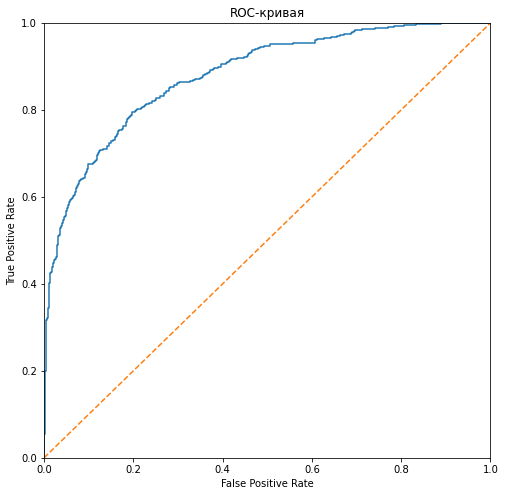

Значение AUC-ROC: 0.8796058024055966


In [42]:
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

print('Значение AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))

**Вывод**

Был дан хорошо подготовленный датасет. Из проблем был только дисбаланс классов и пропущенные значения в столбце `Tenure`.

Признаки `Tenure`, `RowNumber`, `CustomerId`, `Surname` были выброшены, т.к. не влияли на модель.

Признаки `Geography` и `Gender`, выраженные в текстовом формате, были перекодированы в числовой формат методом OHE.

На пайчартах хорошо виден дисбаланс классов `Geography`, `NumOfProducts`, `HasCrCard` и `Exited`.

Для обучения модели выбран популярный алгоритм случайный лес.
Для подбора гиперпараметров и реализации кросс-валидации использован GridSearchCV.

Метрика F1 на несбалансированных данных почти `0.556`, что ниже целевого `0.59`.

Из трёх изучаемых способов балансировки классов наилучший результат (на имеющихся данных) мы получили при взвешивании классов. После финального обучения `F1 == 0.613` на кросс-валидации.

На тестовой выборке значение  `F1 == 0.64`.

Значение AUC-ROC: 0.88